Take our input space to be Bernoulli($\theta$) and our output space also Bernoulli($\theta'$). Then

$$ p_\theta (x) = \theta^x (1-\theta)^{1-x}, x \in \{0, 1\}. $$

Our differential privacy matrix will take the form

$$ \underline{Q} = \begin{pmatrix} p & 1-p \\ 1-p & p \end{pmatrix}. $$

The output distribution is 

$$ \underline{q} = \begin{pmatrix} p & 1-p \\ 1-p & p \end{pmatrix} \begin{pmatrix} \theta \\ 1 - \theta \end{pmatrix} = \begin{pmatrix} 2p\theta + 1 - \theta - p \\ p + \theta - 2p\theta \end{pmatrix}. $$

Equivalently, the output distribution pmf is

$$ q_{\theta p}(x) = (1 + 2p\theta - \theta - p)^x(-2p\theta + p + \theta)^{1-x}. $$

We want to then maximize Fisher Information defined as:

$$ I(p, \theta) = \frac{1}{(p(2\theta - 1) + 1 - \theta)(p(1-2\theta) + \theta)}, \text{with respect to p ($\theta$ is given).} $$

However, we are working in a constrained space and our constraint is

$$ \frac{Q(y=1|x=0)}{Q(y=1|x=1)} = \frac{1-p}{p} \leq e^\epsilon, $$

in addition to $0 \leq p \leq 1$.

Using Lagrange mulipliers and KKT conditions I arrived at

$$ p = \frac{1}{e^\epsilon + 1}, $$

and I am suspicious that it doesn't depend on $\theta$.

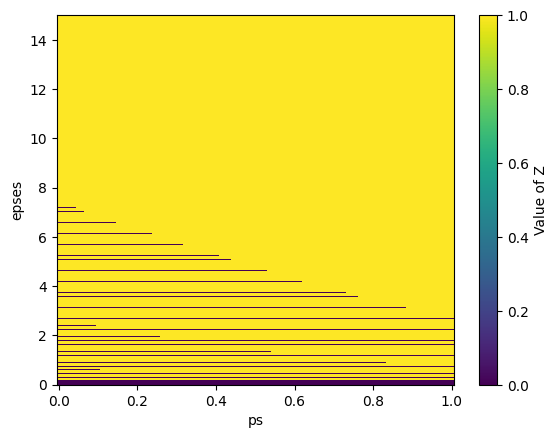

In [22]:
# feasible set visualization
import numpy as np
import matplotlib.pyplot as plt

ps = np.linspace(0, 1, 100)
epses = np.linspace(0, 15, 1000)

z = list()
for p in ps:
    for eps in epses:
        if p == 0:
            z.append(0)
        elif p == 1:
            z.append(1)
        else:
            if (1-p)/p <= np.exp(eps):
                z.append(1)
            else:
                z.append(0)
z = np.array(z)

X, Y = np.meshgrid(ps, epses)
Z = z.reshape(len(epses), len(ps))

plt.pcolor(X, Y, Z, shading="nearest")
plt.xlabel("ps")
plt.ylabel("epses")
plt.colorbar(label="Value of Z")
plt.show()

In [36]:
from scipy.optimize import minimize, LinearConstraint
import pandas as pd

thetas = np.linspace(0.0001, 0.9999, 100)
epsilons = np.linspace(0, 10, 50)

results = []  # Initialize an empty list to store results

for eps in epsilons:
    for theta in thetas:
        # Simplify the constraint by setting the lower bound of p
        p_min = 1 / (np.exp(eps) + 1)
        lc1 = LinearConstraint([1], lb=p_min, ub=1)
        
        # Define the objective function for the optimizer
        def fisher(p):
            first = p * (2 * theta - 1) + 1 - theta
            second = p * (1 - 2 * theta) + theta
            denom = first * second
            if denom == 0:
                return 1e10  # Assign a large number to represent infinity
            return -1 / denom
        
        # Perform the optimization
        res = minimize(fisher, [0.1], constraints=[lc1], method="SLSQP")
        
        # Check if the optimization was successful
        if res.success:
            optimal_p = res.x[0]
            fisher_value = -res.fun
        else:
            optimal_p = np.nan
            fisher_value = np.nan
        
        # Append the results as a dictionary to the list
        results.append({
            'epsilon': eps,
            'theta': theta,
            'optimal_p': optimal_p,
            'fisher_value': fisher_value
        })

# Convert the list of results to a DataFrame after the loops
results_df = pd.DataFrame(results)


In [37]:
results_df

,epsilon,theta,optimal_p,fisher_value
0,0.0,0.000100,0.500000,4.000000
1,0.0,0.010199,0.500000,4.000000
2,0.0,0.020298,0.500000,4.000000
3,0.0,0.030397,0.500000,4.000000
4,0.0,0.040496,0.500000,4.000000
...,...,...,...,...
4995,10.0,0.959504,0.000045,25.710657
4996,10.0,0.969603,0.000045,33.883337
4997,10.0,0.979702,0.000045,50.181263
4998,10.0,0.989801,0.000045,98.633598


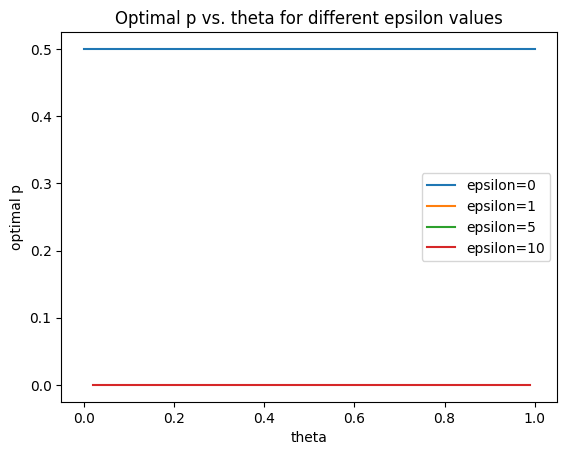

In [38]:
for eps in [0, 1, 5, 10]:
    subset = results_df[results_df['epsilon'] == eps]
    plt.plot(subset['theta'], subset['optimal_p'], label=f'epsilon={eps}')

plt.xlabel('theta')
plt.ylabel('optimal p')
plt.title('Optimal p vs. theta for different epsilon values')
plt.legend()
plt.show()

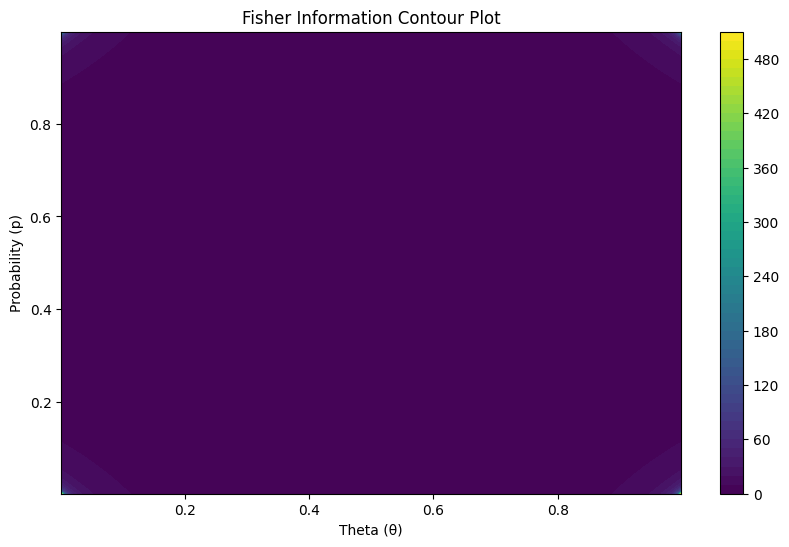

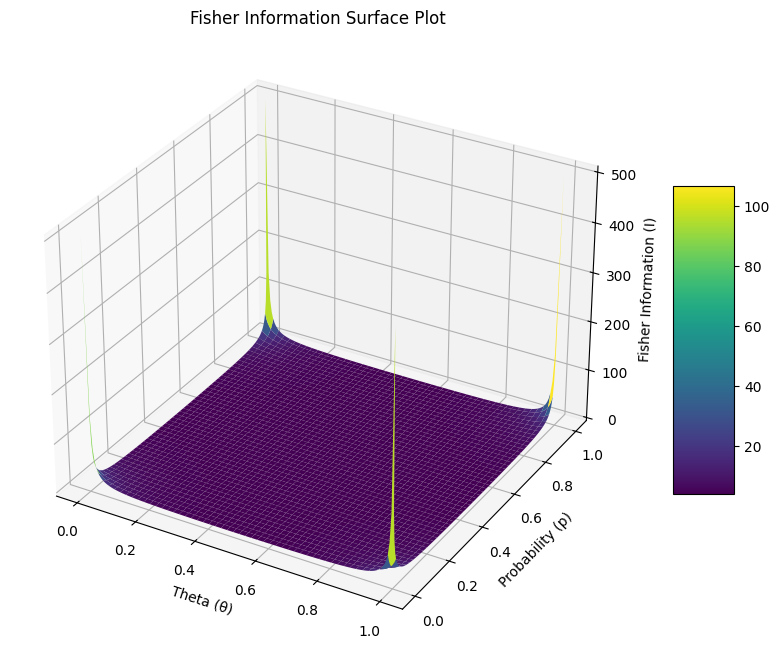

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Define the Fisher information function
def fisher_information(p, theta):
    # Ensure theta and p are numpy arrays for element-wise operations
    p = np.array(p)
    theta = np.array(theta)
    
    # Compute the numerator and denominator terms
    first = p * (2 * theta - 1) + 1 - theta
    second = p * (1 - 2 * theta) + theta
    denom = first * second
    
    # Handle division by zero or undefined values
    with np.errstate(divide='ignore', invalid='ignore'):
        I = np.where(denom != 0, 1 / denom, np.nan)
    
    return I

# Define ranges for theta and p
theta_values = np.linspace(0.001, 0.999, 200)
p_values = np.linspace(0.001, 0.999, 200)

# Create a meshgrid of theta and p
Theta, P = np.meshgrid(theta_values, p_values)

# Compute Fisher information over the grid
I_values = fisher_information(P, Theta)

# Plotting the contour plot
plt.figure(figsize=(10, 6))
contour = plt.contourf(Theta, P, I_values, levels=50, cmap='viridis')
plt.colorbar(contour)
plt.title('Fisher Information Contour Plot')
plt.xlabel('Theta (θ)')
plt.ylabel('Probability (p)')
plt.show()

# Plotting the 3D surface plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Mask invalid values for plotting
I_values_masked = np.ma.array(I_values, mask=np.isnan(I_values))

surf = ax.plot_surface(Theta, P, I_values_masked, cmap=cm.viridis, edgecolor='none')
ax.set_title('Fisher Information Surface Plot')
ax.set_xlabel('Theta (θ)')
ax.set_ylabel('Probability (p)')
ax.set_zlabel('Fisher Information (I)')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()
